In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from utils import show_images, mask_img

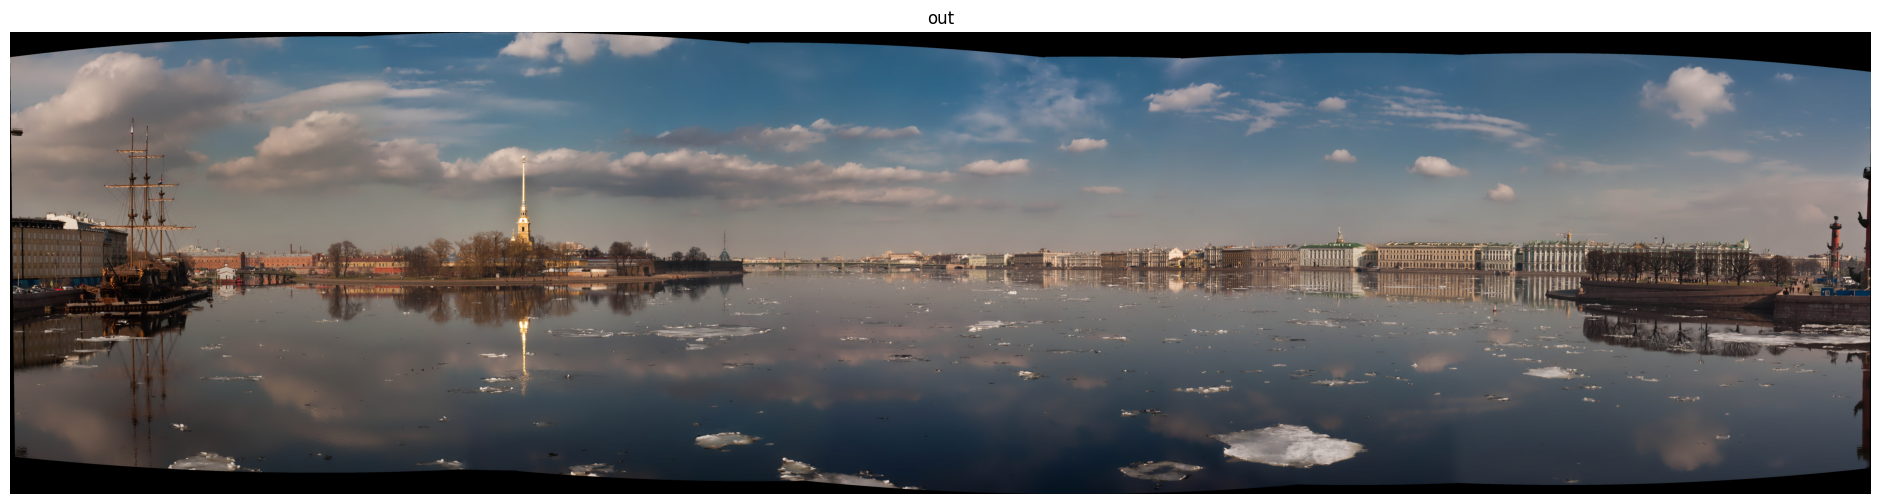

In [8]:
# Hight API
imgs = [cv2.imread(f'./image/stitching/boat{i}.jpg') for i in range(1, 7)]

stitcher = cv2.Stitcher.create()
status, outimg = stitcher.stitch(imgs)

show_images([
    ('out', outimg)
])

In [9]:
import math
def compute_scale(megapix, img):
    if megapix > 0:
        return min(1.0, math.sqrt(megapix * 1e6 / (img.shape[0] * img.shape[1])))
    return 1.0

In [13]:
img_names = [f'./image/stitching/boat{i}.jpg' for i in range(1, 7)]

In [28]:
# 用哪个 feature 方法来找特征点；surf, orb, sift, akaze
finder = cv2.xfeatures2d.SURF.create()
# finder = cv2.SIFT.create()
imgs, img_sizes = [], []

features = []
for nowname in img_names:
    nowimg = cv2.imread(nowname)
    img_sizes.append(np.array(nowimg.shape[0:2]))

    # work_megapix: 图片缩放到多少个像素再去处理；可以加快速度
    work_megapix = 0.6
    work_scale = compute_scale(work_megapix, nowimg) 

    img = cv2.resize(nowimg, None, fx=work_scale, fy=work_scale, interpolation=cv2.INTER_LINEAR_EXACT)
    # 每次计算返回 cv2.detail.ImageFeatures
    features.append(cv2.detail.computeImageFeatures2(finder, img, mask=None))
    imgs.append(img)

In [29]:
# match_conf: 置信度，默认值：surf 0.65; orb 0.3
match_conf = 0.65

# 选择哪个 Match
# matcher = cv2.detail.AffineBestOf2NearestMatcher.create(try_use_gpu=False, match_conf=match_conf)
matcher = cv2.detail.BestOf2NearestMatcher.create(try_use_gpu=False, match_conf=match_conf)
# 如果使用这个，uses range_width to limit number of images to match with. #TODO：暂时不清楚啥意思
# matcher = cv2.detail.BestOf2NearestRangeMatcher(range_width=5, try_use_gpu=False, match_conf=match_conf)
pairwise_matching = matcher.apply2(features)
matcher.collectGarbage()

# conf_thresh: 置信度阈值；即用它来挑选算出的 match
conf_thresh = 1.0

# 打印通过 conf_thresh 的匹配
print(cv2.detail.matchesGraphAsString(img_names, pairwise_matching, conf_thresh))

# 筛选出通过 conf_thresh 的匹配，即有些图片如果和其他图片的匹配程度都很低，就不要这张图片了
indices = cv2.detail.leaveBiggestComponent(features, pairwise_matching, conf_thresh)

imgs = [imgs[x] for x in indices]
img_names = [img_names[x] for x in indices]
img_sizes = [img_sizes[x] for x in indices]


graph matches_graph{
"boat1.jpg" -- "boat2.jpg"[label="Nm=192, Ni=170, C=2.59146"];
"boat1.jpg" -- "boat3.jpg"[label="Nm=52, Ni=48, C=2.0339"];
"boat3.jpg" -- "boat4.jpg"[label="Nm=90, Ni=77, C=2.2"];
"boat4.jpg" -- "boat5.jpg"[label="Nm=121, Ni=95, C=2.14447"];
"boat4.jpg" -- "boat6.jpg"[label="Nm=38, Ni=26, C=1.34021"];
}


In [30]:
# 粗略估计相机参数
estimator = cv2.detail_HomographyBasedEstimator()
# estimator = cv.detail_AffineBasedEstimator()
is_success, cameras = estimator.apply(features, pairwise_matching, None)

In [31]:
# 调整计算出的相机参数

adjuster = cv2.detail_BundleAdjusterRay()
# adjuster = cv2.detail_BundleAdjusterReproj()
# adjuster = cv2.detail_BundleAdjusterAffinePartial()
# adjuster = cv2.detail_NoBundleAdjuster()

adjuster.setConfThresh(conf_thresh)

# 设置相机内参 K 的掩码矩阵，1 表示 考虑，下面就是常见的情况；
# https://www.cnblogs.com/silence-cho/p/16498114.html
refine_mask = np.array([[1,1,1], [0,1,1], [0,0,0]], np.uint8)
adjuster.setRefinementMask(refine_mask)

# OpenCV 的范例 python 代码有 BUG，如果没有这句话后面会报错，需要手动 64F 转为 32F
for camera in cameras:
    camera.R = camera.R.astype(np.float32)

print(cameras[0].R, '\n', cameras[0].focal, '\n')
is_success, cameras = adjuster.apply(features, pairwise_matching, cameras)
print(cameras[0].R, '\n', cameras[0].focal, '\n')

[[ 0.9178533  -0.01151564 -0.56819713]
 [ 0.00481617  1.079764   -0.01273961]
 [ 0.5690516   0.01705129  0.9188689 ]] 
 1096.5768063597643 

[[ 0.84691226 -0.00914534 -0.5316541 ]
 [ 0.00344132  0.9999254  -0.01171845]
 [ 0.53172165  0.00809491  0.84688056]] 
 1084.2694557788384 



In [32]:
# 波形校正
wave_correct = cv2.detail.WAVE_CORRECT_HORIZ
# wave_correct = cv2.detail.WAVE_CORRECT_VERT
if wave_correct is not None:
    rmats = [np.copy(camera.R) for camera in cameras]
    rmats = cv2.detail.waveCorrect(rmats, wave_correct)
    for camera, rmat in zip(cameras, rmats):
        camera.R = rmat

In [33]:
# 变换图片

# 找出每个相机参数的焦段，求出中位数，该参数很重要，其之后会作为 Warp 对象中的 scale 属性。 
median_focal = np.median([cam.focal for cam in cameras])
print('median_focal =', median_focal, '\n')

warp_megapix = 0.6

# 实际上还有很多的 warp_type，看官方的代码
warp_type = [ 'spherical', 'plane', 'affine', 'cylindrical' ][0]

# 如果尺寸一样或者能保证每个图片用的 scale 一样，其实可以直接放到 for 循环外边
# warper = cv.PyRotationWarper(warp_type, median_focal * (seam_scale / work_scale))

corners = []
warped_masks, warped_imgs = [], []
masks = [cv2.UMat(255 * np.ones(img.shape[0:2], np.uint8)) for img in imgs]
for name, mask, camera in zip(img_names, masks, cameras):
    # 一共有两个 scale：找特征点的 scale、变换时的 scale
    work_scale = compute_scale(work_megapix, nowimg)
    warp_scale = compute_scale(warp_megapix, nowimg) 

    # 因为相机参数是在 work_scale 下获取的，而此时 warp 是在 warp_scale 下进行的，所以这里要乘以一个 warp_scale / work_scale
    warper = cv2.PyRotationWarper(warp_type, median_focal * (warp_scale / work_scale))  # warper could be nullptr?
    img = cv2.resize(cv2.imread(name), None, fx=warp_scale, fy=warp_scale, interpolation=cv2.INTER_LINEAR_EXACT)

    # Warp Image
    K = camera.K().astype(np.float32)

    corner, warped_img = warper.warp(img, K, camera.R, cv2.INTER_LINEAR, cv2.BORDER_REFLECT)
    corners.append(corner)
    warped_imgs.append(warped_img.astype(np.float32))

    # Warp Mask
    _, warped_mask = warper.warp(mask, K, camera.R, cv2.INTER_NEAREST, cv2.BORDER_CONSTANT)
    warped_masks.append(warped_mask.get()) 

median_focal = 1083.1808336225154 



In [34]:
# 光照补偿 + 缝隙估计
expos_comp_type = [
    cv2.detail.ExposureCompensator_GAIN_BLOCKS,
    cv2.detail.ExposureCompensator_GAIN,
    cv2.detail.ExposureCompensator_CHANNELS,
    cv2.detail.ExposureCompensator_CHANNELS_BLOCKS,
    cv2.detail.ExposureCompensator_NO,
][0]
expos_comp_nr_feeds = 1
expos_comp_block_size = 32
# expos_comp_nr_filtering = args.expos_comp_nr_filtering
if expos_comp_type == cv2.detail.ExposureCompensator_CHANNELS:
    compensator = cv2.detail_ChannelsCompensator(expos_comp_nr_feeds)
    # compensator.setNrGainsFilteringIterations(expos_comp_nr_filtering)
elif expos_comp_type == cv2.detail.ExposureCompensator_CHANNELS_BLOCKS:
    compensator = cv2.detail_BlocksChannelsCompensator(
        expos_comp_block_size, expos_comp_block_size,
        expos_comp_nr_feeds
    )
    # compensator.setNrGainsFilteringIterations(expos_comp_nr_filtering)
else:
    compensator = cv2.detail.ExposureCompensator_createDefault(expos_comp_type)
compensator.feed(corners=corners, images=warped_imgs, masks=warped_masks)

SEAM_FIND_CHOICES = {}
SEAM_FIND_CHOICES['gc_color'] = cv2.detail_GraphCutSeamFinder('COST_COLOR')
SEAM_FIND_CHOICES['gc_colorgrad'] = cv2.detail_GraphCutSeamFinder('COST_COLOR_GRAD')
SEAM_FIND_CHOICES['dp_color'] = cv2.detail_DpSeamFinder('COLOR')
SEAM_FIND_CHOICES['dp_colorgrad'] = cv2.detail_DpSeamFinder('COLOR_GRAD')
SEAM_FIND_CHOICES['voronoi'] = cv2.detail.SeamFinder_createDefault(cv.detail.SeamFinder_VORONOI_SEAM)
SEAM_FIND_CHOICES['no'] = cv2.detail.SeamFinder_createDefault(cv.detail.SeamFinder_NO)
seam_finder = SEAM_FIND_CHOICES['gc_color']
warped_masks = seam_finder.find(warped_imgs, corners, warped_masks)

In [35]:
# 计算融合后的位置、尺寸
compose_megapix = 0
corners, sizes = [], []
for idx, name in enumerate(img_names):
    img = cv2.imread(name)

    # 之前计算相机各个参数是在 work_scale 下计算的，现在融合是在 compose_scale 下计算的，所以需要乘一个系数
    work_scale = compute_scale(work_megapix, img)
    compose_scale = compute_scale(compose_megapix, img)

    now_ratio = compose_scale / work_scale
    cameras[idx].focal *= now_ratio
    cameras[idx].ppx *= now_ratio
    cameras[idx].ppy *= now_ratio

    warper = cv2.PyRotationWarper(warp_type, scale = median_focal * now_ratio)

    # 注意这里要颠倒一下顺序，width 在前
    # nowshape = (np.array(img.shape[0:2]) * compose_scale).astype(int)
    # print(nowshape)
    # roi = warper.warpRoi((nowshape[1], nowshape[0]), cameras[idx].K().astype(np.float32), cameras[idx].R)
    img = cv2.resize(src=img, dsize=None, fx=compose_scale, fy=compose_scale, interpolation=cv.INTER_LINEAR_EXACT)
    roi = warper.warpRoi((img.shape[1], img.shape[0]), cameras[idx].K().astype(np.float32), cameras[idx].R)
    corners.append(roi[0:2])
    sizes.append(roi[2:4])

full_shape = cv2.detail.resultRoi(corners=corners, sizes=sizes)

In [36]:
# 初始化 blender
blend_strength = 5
blend_width = np.sqrt(full_shape[2] * full_shape[3]) * blend_strength / 100
blender = cv2.detail_MultiBandBlender()
blender.setNumBands((np.log(blend_width) / np.log(2.) - 1.).astype(np.int32))
blender.prepare(full_shape)

In [37]:
# Composition...
for idx, name in enumerate(img_names):
    nowimg = cv2.imread(name)
    img = cv2.resize(src=nowimg, dsize=None, fx=compose_scale, fy=compose_scale, interpolation=cv.INTER_LINEAR_EXACT)

    # 图片变换
    K = cameras[idx].K().astype(np.float32)
    corner, image_warped = warper.warp(img, K, cameras[idx].R, cv2.INTER_LINEAR, cv2.BORDER_REFLECT)

    # 光照补偿 + 缝隙估计
    mask = 255 * np.ones((img.shape[0], img.shape[1]), np.uint8)
    _, mask_warped = warper.warp(mask, K, cameras[idx].R, cv2.INTER_NEAREST, cv2.BORDER_CONSTANT)

    compensator.apply(idx, corners[idx], image_warped, mask_warped)
    dilated_mask = cv2.dilate(warped_masks[idx], None)
    seam_mask = cv2.resize(dilated_mask, (mask_warped.shape[1], mask_warped.shape[0]), 0, 0, cv2.INTER_LINEAR_EXACT)
    mask_warped = cv2.bitwise_and(seam_mask, mask_warped)

    # 生成最后的变换图片，这一步必须要先转成 int16，而且不能在 cv2.Umat() 里面在转换...
    image_warped_s = image_warped.astype(np.int16)
    blender.feed(cv2.UMat(image_warped_s), mask_warped, corners[idx])

(2666, 10719, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2..254].


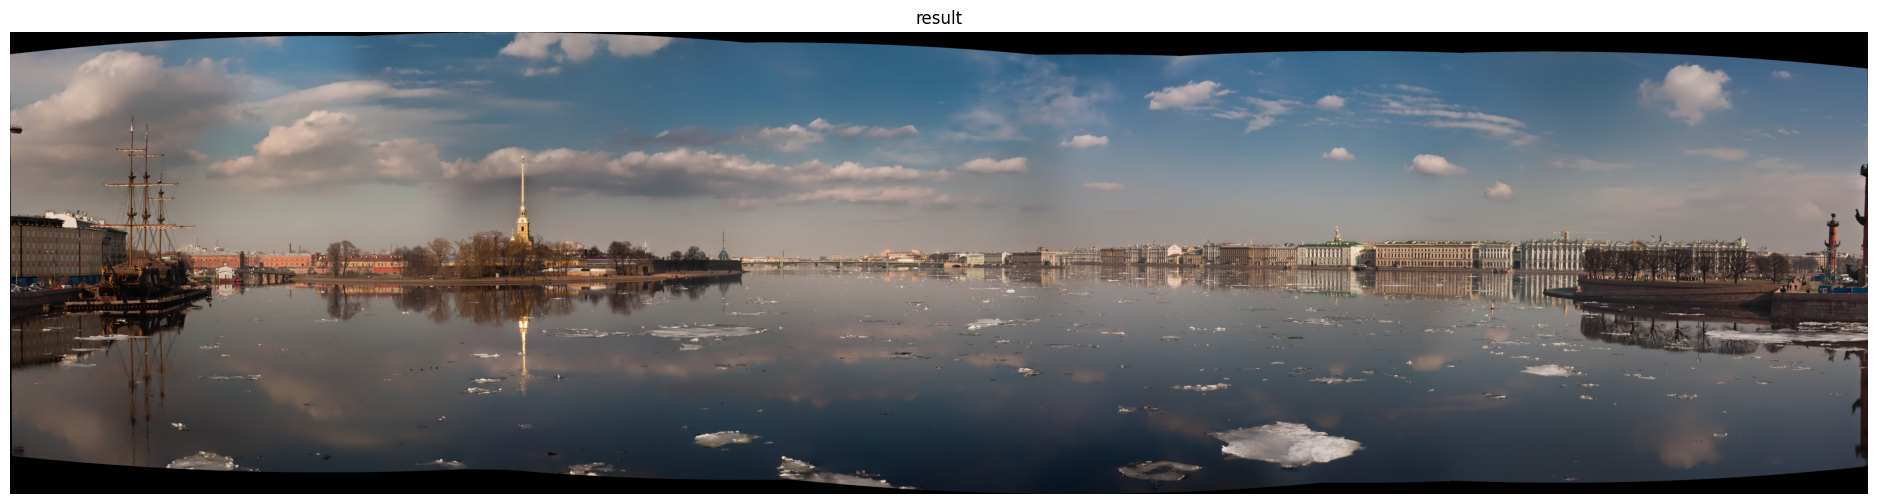

In [38]:
result, result_mask = blender.blend(dst=None, dst_mask=None)
result = result.clip(0, 255).astype(np.uint8)
show_images([
    ('result', result)
])